Dataset Initialization and Directory Verification

In [2]:
from pathlib import Path

DATA_ROOT = Path("Banana Ripeness")

print("Dataset root exists:", DATA_ROOT.exists())
print("Contents:", [p.name for p in DATA_ROOT.iterdir()])



Dataset root exists: True
Contents: ['Banana Ripeness Classification.v1-original-images.folder.zip', 'README.dataset.txt', 'README.roboflow.txt', 'test', 'train', 'valid']


Image Preprocessing and Data Augmentation Strategy

In [3]:
import torchvision.transforms as T

# ImageNet normalization (required for pretrained models)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

# Training transforms (with augmentation)
train_transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=10),
    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Validation / Test transforms (NO augmentation)
eval_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])


Dataset Construction Using ImageFolder

In [4]:
from torchvision.datasets import ImageFolder

train_dir = DATA_ROOT / "train"
valid_dir = DATA_ROOT / "valid"
test_dir  = DATA_ROOT / "test"

train_dataset = ImageFolder(train_dir, transform=train_transform)
valid_dataset = ImageFolder(valid_dir, transform=eval_transform)
test_dataset  = ImageFolder(test_dir, transform=eval_transform)

print("Number of classes:", len(train_dataset.classes))
print("Class names:", train_dataset.classes)


Number of classes: 6
Class names: ['freshripe', 'freshunripe', 'overripe', 'ripe', 'rotten', 'unripe']


Preliminary Dataset Integrity Check

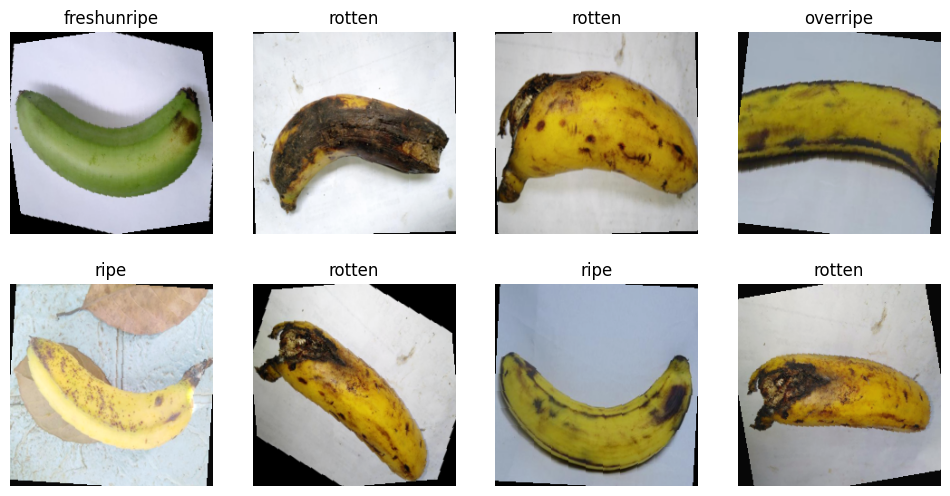

In [5]:
import matplotlib.pyplot as plt
import torch

def show_batch(dataset, n=8):
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for ax in axes.flatten():
        idx = torch.randint(0, len(dataset), (1,)).item()
        img, label = dataset[idx]
        img = img.permute(1, 2, 0)
        img = img * torch.tensor(IMAGENET_STD) + torch.tensor(IMAGENET_MEAN)
        img = img.clamp(0, 1)

        ax.imshow(img)
        ax.set_title(train_dataset.classes[label])
        ax.axis("off")
    plt.show()

show_batch(train_dataset)


In [6]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

Device: cpu


Batch Size Configuration

In [7]:
BATCH_SIZE = 32
NUM_WORKERS = 2

DataLoader Setup for Training, Validation, and Testing

In [8]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=(device.type == "cuda")
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=(device.type == "cuda")
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=(device.type == "cuda")
)

print("Train batches:", len(train_loader))
print("Valid batches:", len(valid_loader))
print("Test batches:", len(test_loader))


Train batches: 123
Valid batches: 36
Test batches: 18


Mini-Batch Shape and Label Verification

In [9]:
images, labels = next(iter(train_loader))

print("Images shape:", images.shape)  # (B, 3, 224, 224)
print("Labels shape:", labels.shape)  # (B,)
print("Label example:", labels[:8])

Images shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Label example: tensor([2, 4, 4, 1, 4, 4, 4, 4])


Initialization of Pretrained ResNet18 Backbone

In [10]:
import torchvision.models as models
import torch.nn as nn

num_classes = len(train_dataset.classes)

resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Replace final classification layer
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

resnet = resnet.to(device)

print(resnet)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Loss Function and Optimizer

In [11]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-4)

Training and Validation Procedure

In [12]:
from tqdm import tqdm

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total


def validate(model, loader, criterion):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total


Baseline Training with Limited Epochs

In [13]:
EPOCHS = 3

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(
        resnet, train_loader, optimizer, criterion
    )
    val_loss, val_acc = validate(
        resnet, valid_loader, criterion
    )

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
    )

Epoch 1/3 | Train Loss: 0.2771, Train Acc: 0.9186 | Val Loss: 0.0958, Val Acc: 0.9777


Epoch 2/3 | Train Loss: 0.1007, Train Acc: 0.9702 | Val Loss: 0.0872, Val Acc: 0.9679


Epoch 3/3 | Train Loss: 0.0750, Train Acc: 0.9763 | Val Loss: 0.1502, Val Acc: 0.9599


Visualization of Training and Validation Performance

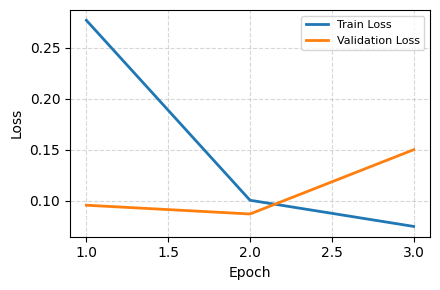

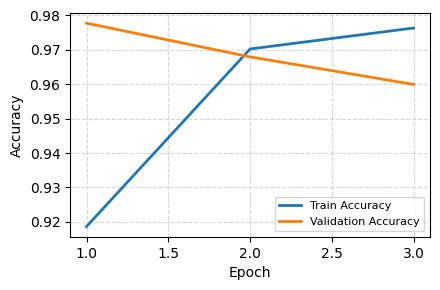

In [14]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

# --- Loss curve ---
plt.figure(figsize=(4.5, 3.0))
plt.plot(epochs, train_losses, label="Train Loss", linewidth=2)
plt.plot(epochs, val_losses, label="Validation Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize=8)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("resnet18_loss.pdf", bbox_inches="tight")
plt.show()

# --- Accuracy curve ---
plt.figure(figsize=(4.5, 3.0))
plt.plot(epochs, train_accs, label="Train Accuracy", linewidth=2)
plt.plot(epochs, val_accs, label="Validation Accuracy", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(fontsize=8)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("resnet18_accuracy.pdf", bbox_inches="tight")
plt.show()


Test Set Evaluation

In [15]:
from sklearn.metrics import accuracy_score, classification_report

resnet.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = resnet(images)
        preds = outputs.argmax(dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

test_acc = accuracy_score(all_labels, all_preds)
print("Test Accuracy (ResNet18):", test_acc)


Test Accuracy (ResNet18): 0.9519572953736655


Per-Class Performance Evaluation

In [16]:
print(
    classification_report(
        all_labels,
        all_preds,
        target_names=train_dataset.classes
    )
)

              precision    recall  f1-score   support

   freshripe       0.98      1.00      0.99       102
 freshunripe       1.00      1.00      1.00        83
    overripe       0.99      0.90      0.94       113
        ripe       0.75      0.96      0.84        52
      rotten       0.99      0.92      0.96       185
      unripe       0.82      1.00      0.90        27

    accuracy                           0.95       562
   macro avg       0.92      0.96      0.94       562
weighted avg       0.96      0.95      0.95       562



Confusion Matrix Analysis on Test Set

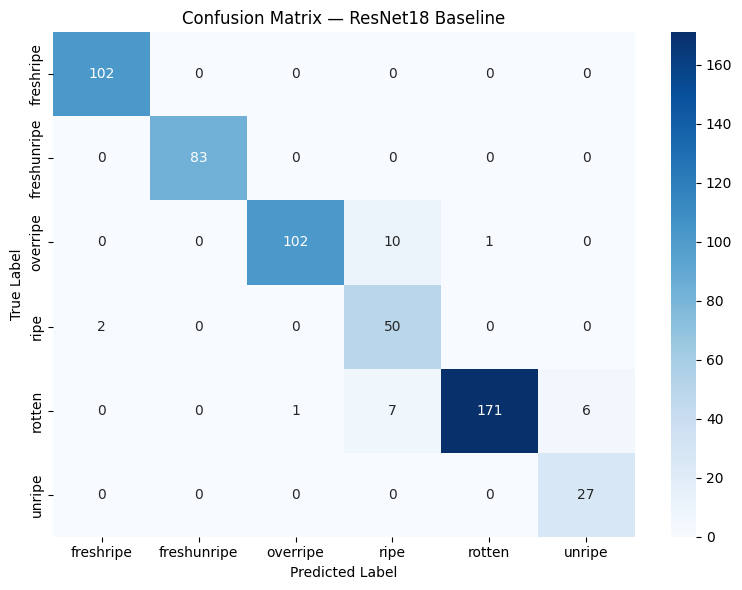

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=train_dataset.classes,
    yticklabels=train_dataset.classes,
    cmap="Blues"
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix — ResNet18 Baseline")
plt.tight_layout()
plt.show()

Load Pre-Trained Vision Transformer

In [18]:
import torchvision.models as models
import torch.nn as nn

vit = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)

# Replace classifier head
vit.heads.head = nn.Linear(vit.heads.head.in_features, num_classes)

vit = vit.to(device)

print(vit)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

Loss and Optimizer

In [19]:
criterion_vit = nn.CrossEntropyLoss()
optimizer_vit = torch.optim.Adam(vit.parameters(), lr=1e-4)

Training Loop

In [20]:
EPOCHS_VIT = 3

vit_train_losses, vit_val_losses = [], []
vit_train_accs, vit_val_accs = [], []

for epoch in range(EPOCHS_VIT):
    train_loss, train_acc = train_one_epoch(
        vit, train_loader, optimizer_vit, criterion_vit
    )
    val_loss, val_acc = validate(
        vit, valid_loader, criterion_vit
    )

    vit_train_losses.append(train_loss)
    vit_val_losses.append(val_loss)
    vit_train_accs.append(train_acc)
    vit_val_accs.append(val_acc)

    print(
        f"Epoch {epoch+1}/{EPOCHS_VIT} | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
    )

Epoch 1/3 | Train Loss: 0.2537, Train Acc: 0.9183 | Val Loss: 0.1151, Val Acc: 0.9653


Epoch 2/3 | Train Loss: 0.0868, Train Acc: 0.9725 | Val Loss: 0.0694, Val Acc: 0.9786


Epoch 3/3 | Train Loss: 0.0791, Train Acc: 0.9753 | Val Loss: 0.0691, Val Acc: 0.9822


Build Feature Extraction (ResNet + ViT)

In [21]:
#CNN Feature Extractor
import torch.nn as nn

class ResNetFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = models.resnet18(
            weights=models.ResNet18_Weights.IMAGENET1K_V1
        )
        self.features = nn.Sequential(*list(backbone.children())[:-1])  # remove fc
        self.out_dim = 512

    def forward(self, x):
        x = self.features(x)
        return x.view(x.size(0), -1)


In [22]:
#ViT Feature Extractor
class ViTFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.vit_b_16(
            weights=models.ViT_B_16_Weights.IMAGENET1K_V1
        )

        # Remove classifier head
        self.backbone.heads = nn.Identity()

        # Output dimension of ViT-B/16
        self.out_dim = 768

    def forward(self, x):
        # Forward now returns CLS embedding
        return self.backbone(x)

CNN–Transformer Feature Fusion Architecture

In [23]:
class CNNTransformerFusion(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.cnn = ResNetFeatureExtractor()
        self.vit = ViTFeatureExtractor()

        fusion_dim = self.cnn.out_dim + self.vit.out_dim

        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        cnn_feat = self.cnn(x)
        vit_feat = self.vit(x)
        fused = torch.cat((cnn_feat, vit_feat), dim=1)
        return self.classifier(fused)


In [24]:
fusion_model = CNNTransformerFusion(num_classes=6).to(device)

criterion_fusion = nn.CrossEntropyLoss()
optimizer_fusion = torch.optim.Adam(
    fusion_model.parameters(), lr=1e-4
)

Training Procedure for the Fusion Model

In [25]:
EPOCHS_FUSION = 2

fusion_train_losses, fusion_val_losses = [], []
fusion_train_accs, fusion_val_accs = [], []

for epoch in range(EPOCHS_FUSION):
    train_loss, train_acc = train_one_epoch(
        fusion_model, train_loader, optimizer_fusion, criterion_fusion
    )
    val_loss, val_acc = validate(
        fusion_model, valid_loader, criterion_fusion
    )

    fusion_train_losses.append(train_loss)
    fusion_val_losses.append(val_loss)
    fusion_train_accs.append(train_acc)
    fusion_val_accs.append(val_acc)

    print(
        f"[Fusion] Epoch {epoch+1}/{EPOCHS_FUSION} | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
    )


[Fusion] Epoch 1/2 | Train Loss: 0.2674, Train Acc: 0.9148 | Val Loss: 0.1245, Val Acc: 0.9617


[Fusion] Epoch 2/2 | Train Loss: 0.1003, Train Acc: 0.9677 | Val Loss: 0.0826, Val Acc: 0.9768


Visualizations of Important Data

In [26]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)
from PIL import Image
import random
from pathlib import Path


Dataset Sanity and Class Distribution

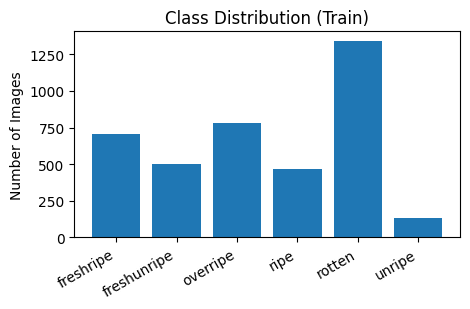

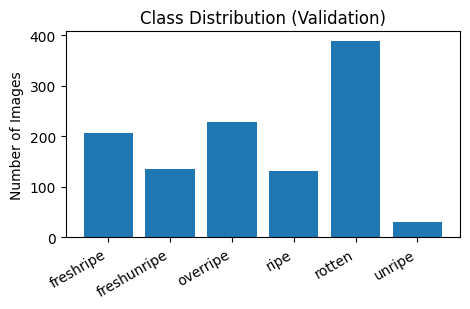

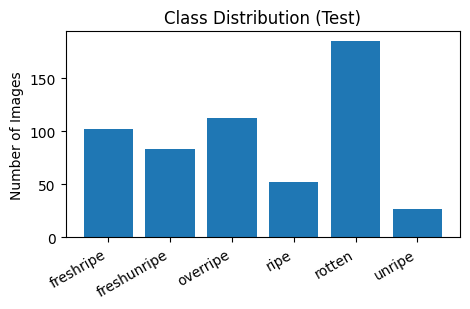

In [27]:
def plot_class_distribution(dataset, title, save_name):
    labels = [dataset.targets[i] for i in range(len(dataset))]
    counts = Counter(labels)

    classes = dataset.classes
    values = [counts[i] for i in range(len(classes))]

    plt.figure(figsize=(4.8, 3.2))
    plt.bar(classes, values)
    plt.xticks(rotation=30, ha="right")
    plt.ylabel("Number of Images")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(save_name, format="pdf", bbox_inches="tight")
    plt.show()


plot_class_distribution(train_dataset, "Class Distribution (Train)", "dataset_train_distribution.pdf")
plot_class_distribution(valid_dataset, "Class Distribution (Validation)", "dataset_valid_distribution.pdf")
plot_class_distribution(test_dataset,  "Class Distribution (Test)",  "dataset_test_distribution.pdf")


Image Sanity Check

In [ ]:
def show_class_samples_compact(dataset, samples_per_class=2):
    num_classes = len(dataset.classes)

    fig, axes = plt.subplots(
        nrows=num_classes,
        ncols=samples_per_class,
        figsize=(6.5, num_classes * 1.2)
    )

    for class_idx in range(num_classes):
        class_indices = [
            i for i, t in enumerate(dataset.targets) if t == class_idx
        ]
        sampled = random.sample(class_indices, samples_per_class)

        for col_idx, img_idx in enumerate(sampled):
            img, _ = dataset[img_idx]
            img = img.permute(1, 2, 0)
            img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
            img = img.clamp(0, 1)

            ax = axes[class_idx, col_idx]
            ax.imshow(img)
            ax.set_aspect("equal")
            ax.axis("off")

    plt.subplots_adjust(left=0.02, right=0.98, top=0.98, bottom=0.02, wspace=0.05, hspace=0.05)
    plt.savefig("dataset_sanity_samples.pdf", bbox_inches="tight")
    plt.show()

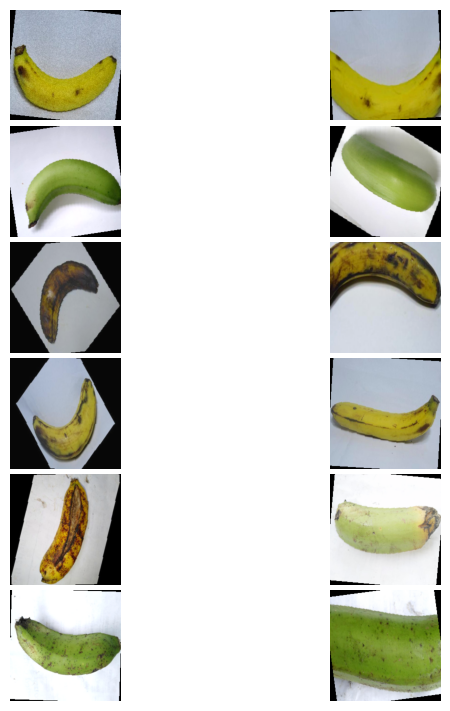

In [41]:
show_class_samples_compact(train_dataset)

Training Curves

In [30]:
def plot_curves(train_vals, val_vals, ylabel, title, save_name):
    epochs = range(1, len(train_vals) + 1)

    plt.figure(figsize=(4.5, 3.0))
    plt.plot(epochs, train_vals, label="Train", linewidth=2)
    plt.plot(epochs, val_vals, label="Validation", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.legend(fontsize=8)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.savefig(save_name, format="pdf", bbox_inches="tight")
    plt.show()


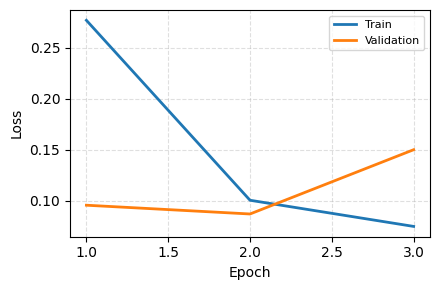

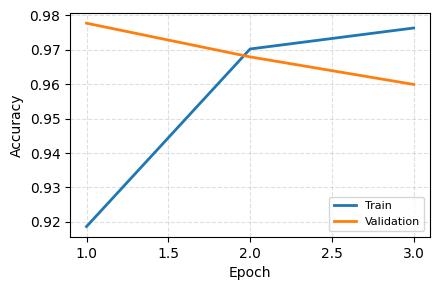

In [31]:
#ResNet18
plot_curves(train_losses, val_losses, "Loss", "ResNet18 Loss", "resnet18_loss.pdf")
plot_curves(train_accs, val_accs, "Accuracy", "ResNet18 Accuracy", "resnet18_accuracy.pdf")

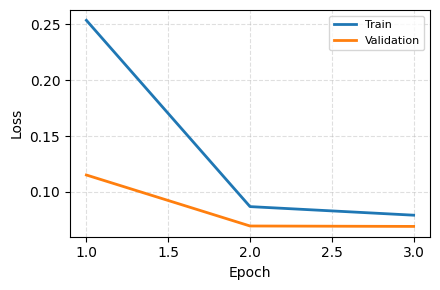

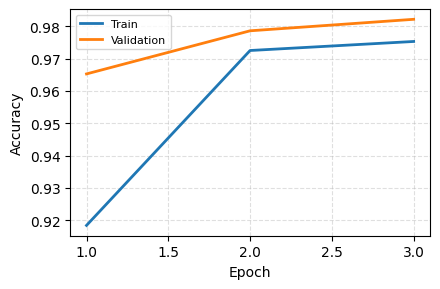

In [32]:
#ViT
plot_curves(vit_train_losses, vit_val_losses, "Loss", "ViT Loss", "vit_loss.pdf")
plot_curves(vit_train_accs, vit_val_accs, "Accuracy", "ViT Accuracy", "vit_accuracy.pdf")

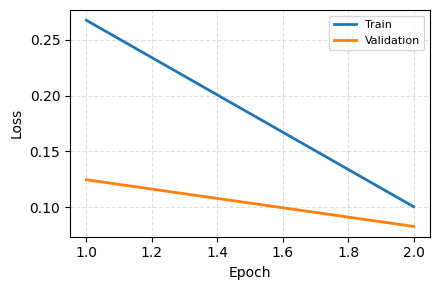

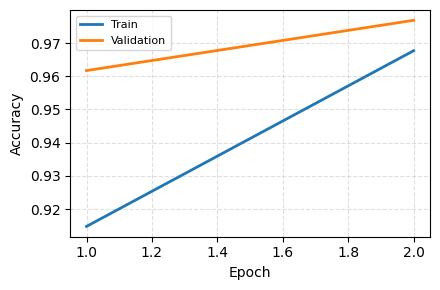

In [33]:
#Fusion
plot_curves(fusion_train_losses, fusion_val_losses, "Loss", "Fusion Loss", "fusion_loss.pdf")
plot_curves(fusion_train_accs, fusion_val_accs, "Accuracy", "Fusion Accuracy", "fusion_accuracy.pdf")

Test Set Evaluation

In [34]:
def evaluate_model(model, loader, class_names, title_prefix):
    model.eval()
    preds, labels = [], []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            out = model(x)
            preds.extend(out.argmax(1).cpu().numpy())
            labels.extend(y.numpy())

    acc = accuracy_score(labels, preds)
    print(f"{title_prefix} Test Accuracy:", acc)
    print(classification_report(labels, preds, target_names=class_names))

    cm = confusion_matrix(labels, preds)

    plt.figure(figsize=(5.0, 4.0))
    sns.heatmap(
        cm, annot=True, fmt="d",
        xticklabels=class_names,
        yticklabels=class_names,
        cmap="Blues",
        cbar=False
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{title_prefix} Confusion Matrix")
    plt.tight_layout()
    plt.savefig(f"{title_prefix.lower().replace(' ', '_')}_confusion.pdf", bbox_inches="tight")
    plt.show()

ResNet18 Test Accuracy: 0.9519572953736655
              precision    recall  f1-score   support

   freshripe       0.98      1.00      0.99       102
 freshunripe       1.00      1.00      1.00        83
    overripe       0.99      0.90      0.94       113
        ripe       0.75      0.96      0.84        52
      rotten       0.99      0.92      0.96       185
      unripe       0.82      1.00      0.90        27

    accuracy                           0.95       562
   macro avg       0.92      0.96      0.94       562
weighted avg       0.96      0.95      0.95       562



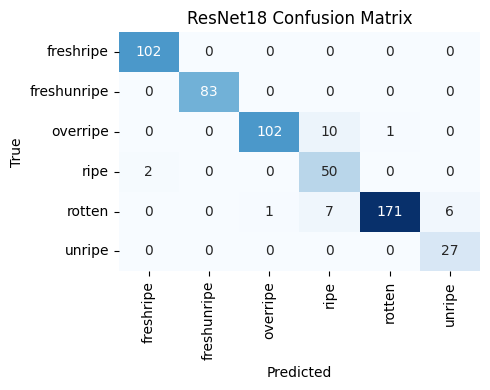

ViT Test Accuracy: 0.9875444839857651
              precision    recall  f1-score   support

   freshripe       0.99      1.00      1.00       102
 freshunripe       0.99      1.00      0.99        83
    overripe       0.98      0.99      0.99       113
        ripe       0.98      0.98      0.98        52
      rotten       1.00      0.98      0.99       185
      unripe       0.93      0.96      0.95        27

    accuracy                           0.99       562
   macro avg       0.98      0.99      0.98       562
weighted avg       0.99      0.99      0.99       562



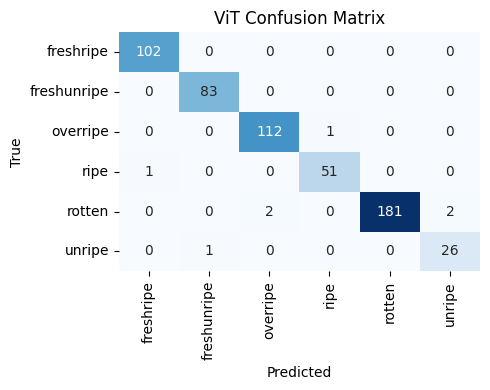

Fusion Test Accuracy: 0.9715302491103203
              precision    recall  f1-score   support

   freshripe       0.95      1.00      0.98       102
 freshunripe       1.00      1.00      1.00        83
    overripe       0.96      0.99      0.97       113
        ripe       0.98      0.85      0.91        52
      rotten       0.98      0.97      0.98       185
      unripe       0.93      0.96      0.95        27

    accuracy                           0.97       562
   macro avg       0.97      0.96      0.96       562
weighted avg       0.97      0.97      0.97       562



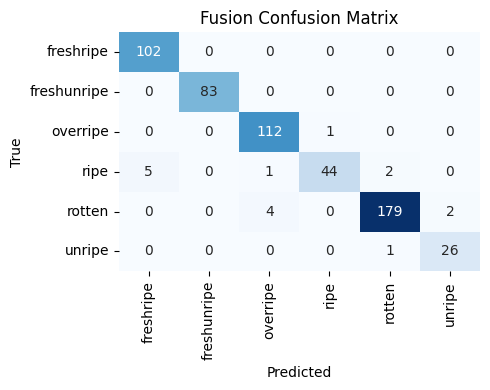

In [35]:
evaluate_model(resnet, test_loader, train_dataset.classes, "ResNet18")
evaluate_model(vit, test_loader, train_dataset.classes, "ViT")
evaluate_model(fusion_model, test_loader, train_dataset.classes, "Fusion")